# Convolution
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

## Forward Discrete transform

In [45]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

from ipynb.fs.full.task1 import convert_pgm_to_matrix, show_image_greyscale

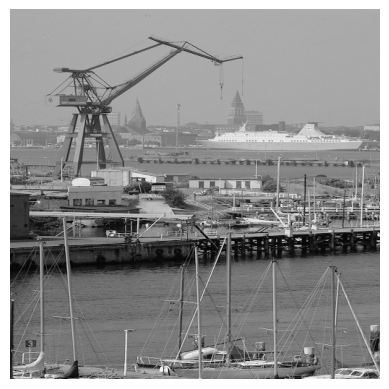

In [46]:
# Load image
im = convert_pgm_to_matrix("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [47]:
# Utility function
def show_pic(pic):
    plt.imshow(pic, cmap=plt.cm.gray)

def add_right_padding(im):
    right_padding = np.zeros((im.shape[0], 1))
    return np.concatenate((im, right_padding), axis=1)

def add_bottom_padding(im):
    bottom_padding = np.zeros((1, im.shape[1]))
    return np.concatenate((im, bottom_padding))

In [66]:
def fdwt_haar_coeff(im):
    """
    Perform forward wavelet transform (single level) on a 2D matrix.
    Args:
        im (ndarray): Input 2D matrix (grayscale image).
    
    Returns:
        tuple: LL, LH, HL, HH subbands as 2D matrices.
    """
    # For odd number column, add padding to keep the information in the last column
    num_columns = im.shape[1]
    if num_columns%2 != 0:
        im = add_right_padding(im)

    num_rows = im.shape[0]
    num_columns = im.shape[1]

    # Using haar filter coefficient
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)


    # Prepare array to store the result of convoluting image's row through filter
    ## For low pass 
    L = np.zeros((num_rows, num_columns))
    ## For high pass
    H = np.zeros((num_rows, num_columns))

    ## Go through all rows. Stride by 1
    for i in range(num_rows):
        for j in range(num_columns):
            window = im[i][j:j+2]
            if window.shape[0] != 2:
                break

            ## Apply dot product on the filter and part of an image
            L[i][j] = np.dot(low_pass_filter, window)
            H[i][j] = np.dot(high_pass_filter, window)
    
    print(" ====== L ======= ")
    print(L)

    print(" ====== H ======= ")
    print(H)

    ## Downsampling the column by 2
    L = L[:, ::2]
    H = H[:, ::2]

    print(" ====== L Down sampling ======= ")
    print(L)

    print(" ====== H Down sampling ======= ")
    print(H)

    # For odd number rows, add padding to keep the information in the last row
    if num_rows%2:
        L = add_bottom_padding(L)
        H = add_bottom_padding(H)

    # Prepare array to store the result of convoluting L and H by columns
    LL = np.zeros((num_rows, num_columns//2))  # Low-pass along rows, then columns
    LH = np.zeros((num_rows, num_columns//2))  # Low-pass rows, high-pass columns
    HL = np.zeros((num_rows, num_columns//2))  # High-pass rows, low-pass columns
    HH = np.zeros((num_rows, num_columns//2))  # High-pass rows, high-pass columns

    for i in range (L.shape[0]): # num row before paddding
        for j in range (L.shape[1]):
            window = L[i:i+2, j]
            if window.shape[0] != 2:
                break

            LL[i,j] = np.dot(low_pass_filter, window)
            LH[i,j] = np.dot(high_pass_filter, window)

            window = H[i:i+2, j]
            if window.shape[0] != 2:
                break
            HL[i,j] = np.dot(low_pass_filter, window)
            HH[i,j] = np.dot(high_pass_filter, window)
    
    print(" ====== LL ======= ")
    print(LL)

    print(" ====== LH ======= ")
    print(LH)

    print(" ====== HL ======= ")
    print(HL)

    print(" ====== HH ======= ")
    print(HH)
    
    ## Downsampling the row by 2
    LL = LL[::2, :]
    LH = LH[::2, :]
    HL = HL[::2, :]
    HH = HH[::2, :]

    print(" ====== LL Down ======= ")
    print(LL)

    print(" ====== LH Down ======= ")
    print(LH)

    print(" ====== HL Down ======= ")
    print(HL)

    print(" ====== HH Down ======= ")
    print(HH)
    
            
    return LL, LH, HL, HH 

In [49]:
def show_images_4_grids(LL, LH, HL, HH, level):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"Wavelet transformation Level {level}")
    plt.show()

In [50]:
def forward_wavelet_transform(image, level):
    for l in range(1, level+1):
        LL, LH, HL, HH = fdwt_haar_coeff(image)
        image = LL
        show_images_4_grids(LL, LH, HL, HH, l)
    
    return LL, LH, HL, HH


In [65]:
# LL, LH, HL, HH = forward_wavelet_transform(im, 3)

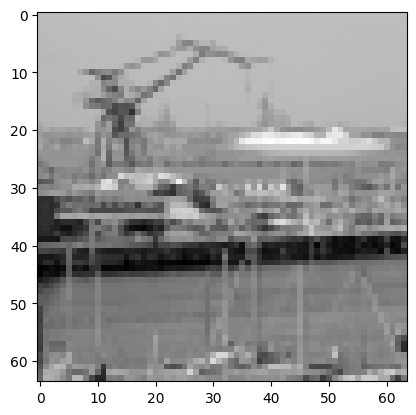

In [52]:
show_pic(LL)

## Reverse

In [53]:
import numpy as np
from scipy.signal import convolve2d

def upsample_2D_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols), dtype=matrix.dtype)
    upsampled[::2, :] = matrix  # Insert zeros at even rows
    return upsampled

def upsample_2D_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols), dtype=matrix.dtype)
    upsampled[:, ::2] = matrix  # Insert zeros at even columns
    return upsampled

def inverse_wavelet_2D(LL, LH, HL, HH, low_pass_filter, high_pass_filter):
    """
    Perform the 2D Inverse Discrete Wavelet Transform (IDWT).

    Returns:
        Reconstructed 2D image (numpy array)
    """

    # Upsample rows and convolve with reconstruction filters
    def row_reconstruction(coeffs, filter):
        upsampled_rows = upsample_2D_rows(coeffs)  # Upsample rows
        filtered_rows = convolve2d(upsampled_rows, filter[:, None], mode='full')  # Row convolution
        
        return filtered_rows

    def column_reconstruction(coeffs, filter):
        upsampled_cols = upsample_2D_cols(coeffs)  # Upsample columns
        filtered_cols = convolve2d(upsampled_cols, filter[None, :], mode='full')  # Column convolution
        return filtered_cols

    # Convolve and combine all components
    D = row_reconstruction(HH, high_pass_filter)
    V = row_reconstruction(HL, low_pass_filter)
    H = row_reconstruction(LH, high_pass_filter)
    A = row_reconstruction(LL, low_pass_filter) 

    D_V = D+V
    A_H = A+H


    X = column_reconstruction(D_V, high_pass_filter)
    Y = column_reconstruction(A_H, low_pass_filter)


    # Combine all contributions
    reconstructed_image = X + Y 

    # Crop the central part to match the correct size
    rows, cols = LL.shape
    reconstructed_image = reconstructed_image[1:2*rows+1, 1:2*cols+1]

    return reconstructed_image

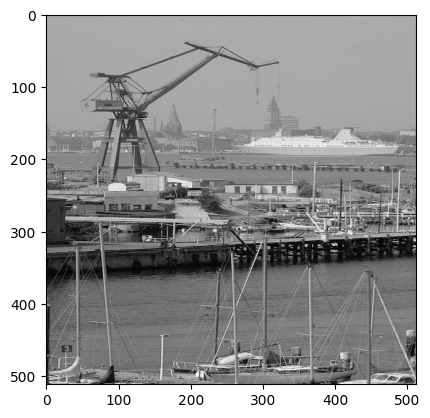

In [54]:
show_pic(im)

In [55]:
LL1, LH1, HL1, HH1 = fdwt_haar_coeff(im)
LL2, LH2, HL2, HH2 = fdwt_haar_coeff(LL1)
LL3, LH3, HL3, HH3 = fdwt_haar_coeff(LL2)

In [62]:
low_pass_filter = np.array([1, 1]) / np.sqrt(2)
high_pass_filter = np.array([1, -1]) / np.sqrt(2)

reconstructed_LL2 = inverse_wavelet_2D(LL3, LH3, HL3, HH3, low_pass_filter, high_pass_filter)
reconstructed_LL1 = inverse_wavelet_2D(reconstructed_LL2, LH2, HL2, HH2, low_pass_filter, high_pass_filter)
reconstructed_image = inverse_wavelet_2D(reconstructed_LL1, LH1, HL1, HH1, low_pass_filter, high_pass_filter)

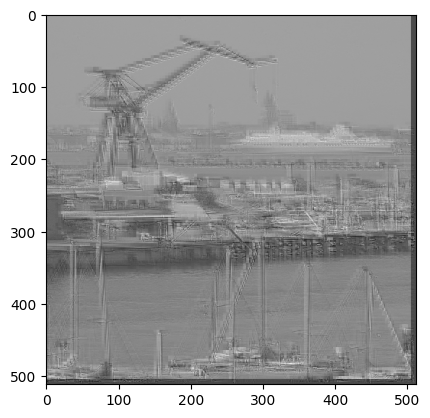

In [63]:
show_pic(reconstructed_image)

In [67]:
a = np.arange(12).reshape(3,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [69]:
LL, LH, HL, HH = fdwt_haar_coeff(a)

 ====== L ======= 
[[ 0.70710678  2.12132034  3.53553391  0.        ]
 [ 6.36396103  7.77817459  9.19238816  0.        ]
 [12.02081528 13.43502884 14.8492424   0.        ]]
 ====== H ======= 
[[-0.70710678 -0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678 -0.70710678  0.        ]]
 ====== L Down sampling ======= 
[[ 0.70710678  3.53553391]
 [ 6.36396103  9.19238816]
 [12.02081528 14.8492424 ]]
 ====== H Down sampling ======= 
[[-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]]
 ====== LL ======= 
[[ 5.   9. ]
 [13.  17. ]
 [ 8.5 10.5]]
 ====== LH ======= 
[[-4.  -4. ]
 [-4.  -4. ]
 [ 8.5 10.5]]
 ====== HL ======= 
[[-1.  -1. ]
 [-1.  -1. ]
 [-0.5 -0.5]]
 ====== HH ======= 
[[ 0.00000000e+00 -2.77555756e-16]
 [ 3.33066907e-16  0.00000000e+00]
 [-5.00000000e-01 -5.00000000e-01]]
 ====== LL Down ======= 
[[ 5.   9. ]
 [ 8.5 10.5]]
 ====== LH Down ======= 
[[-4.  -4. ]
 [ 8.5 10.5]]
 ====== HL Dow

In [71]:
LL_Up = upsample_2D_rows(LL)
LL_Up

array([[ 5. ,  9. ],
       [ 0. ,  0. ],
       [ 8.5, 10.5],
       [ 0. ,  0. ]])

In [77]:
LH_Up = upsample_2D_rows(LH)
LH_Up

array([[-4. , -4. ],
       [ 0. ,  0. ],
       [ 8.5, 10.5],
       [ 0. ,  0. ]])

In [ ]:
def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result

def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result


def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols), dtype=matrix.dtype)
    upsampled[::2, :] = matrix  # Insert zeros at even rows
    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols), dtype=matrix.dtype)
    upsampled[:, ::2] = matrix  # Insert zeros at even columns
    return upsampled

In [ ]:
def inverse_wavelet_transform(LL, LH, HL, HH, low_pass_filter, high_pass_filter):
    reconstructed_L = convolve_by_row(upsample_2D_rows(LH), high_pass_filter) + convolve_by_row(upsample_rows(LL), low_pass_filter) 
    reconstructed_H = convolve_by_row(upsample_2D_rows(HH), high_pass_filter) + convolve_by_row(upsample_rows(HL), low_pass_filter)

    reconstructed_image = convolve_by_column(upsample_cols(reconstructed_L), low_pass_filter) + convolve_by_column(upsample_cols(reconstructed_H), high_pass_filter)

    return reconstructed_image

In [116]:
def add_right_padding(im):
    right_padding = np.zeros((im.shape[0], 1))
    return np.concatenate((im, right_padding), axis=1)

def add_bottom_padding(im):
    bottom_padding = np.zeros((1, im.shape[1]))
    return np.concatenate((im, bottom_padding))

def padding_preprocessing_col(im):
    num_columns = im.shape[1]
    if num_columns%2 != 0:
        im = add_right_padding(im)
    
    return im

def padding_preprocessing_row(im):
    num_rows = im.shape[0]
    if num_rows%2 != 0:
        im = add_bottom_padding(im)
    
    return im

def downsample_cols(im):
    return im[:, ::2]

def downsample_rows(im):
    return im[::2, :]

low_pass_filter = np.array([1, 1]) / np.sqrt(2)
high_pass_filter = np.array([1, -1]) / np.sqrt(2)

In [119]:
L = downsample_cols(convolve_by_column(padding_preprocessing_col(im), low_pass_filter))
H = downsample_cols(convolve_by_column(padding_preprocessing_col(im), high_pass_filter))

LL = downsample_rows(convolve_by_row(padding_preprocessing_row(L), low_pass_filter))
LH = downsample_rows(convolve_by_row(padding_preprocessing_row(L), high_pass_filter))
HL = downsample_rows(convolve_by_row(padding_preprocessing_row(H), low_pass_filter))
HH = downsample_rows(convolve_by_row(padding_preprocessing_row(H), high_pass_filter))


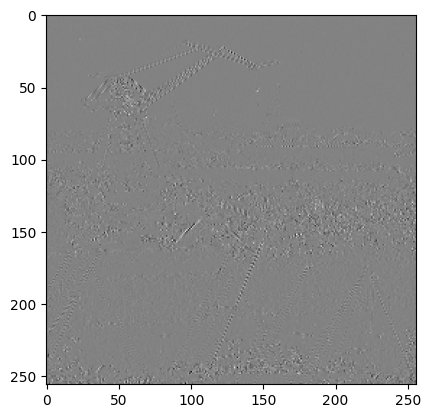

In [122]:
show_pic(HH)